In [1]:
import pandas as pd
import numpy as np
import gudhi as gd
from gudhi.point_cloud.timedelay import TimeDelayEmbedding
from gudhi.hera import wasserstein_distance
from gudhi.representations import PersistenceImage
from gudhi.representations.metrics import WassersteinDistance
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.manifold import MDS
import os
from tqdm.notebook import tqdm
from sklearn.covariance import ledoit_wolf

import geomstats.backend as gs
from geomstats.datasets.prepare_emg_data import TimeSeriesCovariance
from geomstats.learning.preprocessing import ToTangentSpace
from geomstats.learning.frechet_mean import FrechetMean
from geomstats.geometry.spd_matrices import SPDMetricAffine, SPDMetricBuresWasserstein, SPDMetricEuclidean, SPDMetricLogEuclidean
import geomstats.geometry.spd_matrices as spd
gs.random.seed(2021)

#%matplotlib widget

INFO: Using numpy backend


In [2]:
datapath =".\\data\\timeseries\\good2"
filelist = os.listdir(datapath)
print(sorted(filelist))
good_labels  =sorted(filelist)
good_time_series = [np.loadtxt(os.path.join(datapath,f)) for f in sorted(filelist)]
datapath =".\\data\\timeseries\\bad2"
filelist = os.listdir(datapath)
print(sorted(filelist))
bad_labels = sorted(filelist)
bad_time_series = [np.loadtxt(os.path.join(datapath,f)) for f in sorted(filelist)]

print(good_time_series[0])

['signal05_good.txt', 'signal10_good.txt', 'signal15_good.txt', 'signal20_good.txt', 'signal25_good.txt']
['signal05_bad.txt', 'signal10_bad.txt', 'signal15_bad.txt', 'signal20_bad.txt', 'signal25_bad.txt']
[ 0.2504463   0.07998543 -0.35629045 ... -0.55235447 -0.22336272
 -0.37701057]


In [3]:
dim = 1041
delay = 48
skip = 1

tde = TimeDelayEmbedding(dim = dim, delay=delay, skip=skip)
good_point_clouds = tde.transform(good_time_series)
bad_point_clouds = tde.transform(bad_time_series)
for i in range(0,len(good_point_clouds)):
    good_point_clouds[i] = good_point_clouds[i]-np.mean(good_point_clouds[i],1)[:, None]
    good_point_clouds[i] = good_point_clouds[i]/np.sqrt(np.sum(good_point_clouds[i]**2, 1))[:, None]
    bad_point_clouds[i] = bad_point_clouds[i]-np.mean(bad_point_clouds[i],1)[:, None]
    bad_point_clouds[i] = bad_point_clouds[i]/np.sqrt(np.sum(good_point_clouds[i]**2, 1))[:, None]


In [4]:
good_covs = [ledoit_wolf(np.array(ts))[0] for ts in good_point_clouds]
bad_covs = [ledoit_wolf(np.array(ts))[0] for ts in bad_point_clouds]


In [5]:
print(good_point_clouds[0].shape)
print(good_covs[0].shape)

(80, 1041)
(1041, 1041)


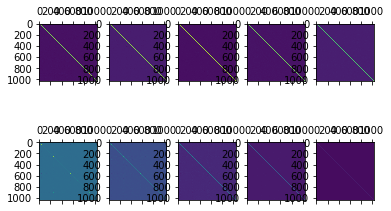

In [6]:
f,ax = plt.subplots(2,5)
for i in range(0,5):
    ax[0][i].matshow(good_covs[i])
    ax[1][i].matshow(bad_covs[i])

plt.show()

In [7]:
manifold = spd.SPDMatrices(dim)
metric = SPDMetricAffine(dim)

manifold.belongs(gs.array(good_covs[0]))

True

In [8]:
tangent_space_projections = ToTangentSpace(metric).fit_transform(gs.array(good_covs+bad_covs))

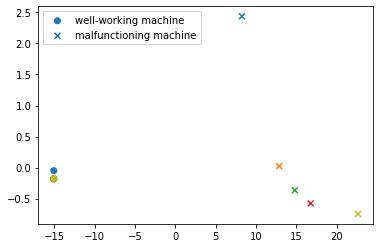

In [9]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
emb = pca.fit_transform(tangent_space_projections)

f,ax = plt.subplots()
colors = ["tab:blue","tab:orange", "tab:green", "tab:red","tab:olive"]
ax.scatter(emb[:5,0],emb[:5,1], marker = "o", c= colors, label="well-working machine")
ax.scatter(emb[5:,0],emb[5:,1], marker = "x", c=colors, label="malfunctioning machine")
ax.legend()
plt.show()

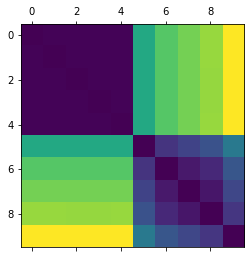

In [11]:
dist_matrix = metric.dist_pairwise(gs.array(good_covs+bad_covs))
plt.matshow(dist_matrix)

c:\Users\Niklas\anaconda3\lib\site-packages\sklearn\manifold\_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


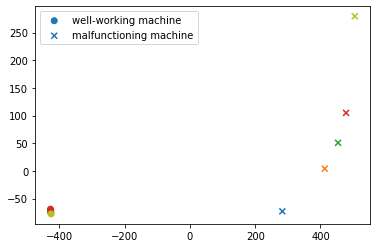

In [12]:
mds = MDS(n_components=2, metric="precomputed")
emb =mds.fit_transform(dist_matrix)
f,ax = plt.subplots()
colors = ["tab:blue","tab:orange", "tab:green", "tab:red","tab:olive"]
ax.scatter(emb[:5,0],emb[:5,1], marker = "o", c= colors, label="well-working machine")
ax.scatter(emb[5:,0],emb[5:,1], marker = "x", c=colors, label="malfunctioning machine")
ax.legend()
plt.show()


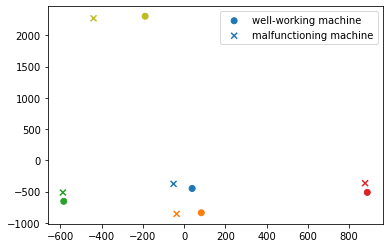

In [13]:
mds = MDS(n_components=2)
emb =mds.fit_transform(np.array(good_time_series+bad_time_series))
f,ax = plt.subplots()
colors = ["tab:blue","tab:orange", "tab:green", "tab:red","tab:olive"]
ax.scatter(emb[:5,0],emb[:5,1], marker = "o", c= colors, label="well-working machine")
ax.scatter(emb[5:,0],emb[5:,1], marker = "x", c=colors, label="malfunctioning machine")
ax.legend()
plt.show()

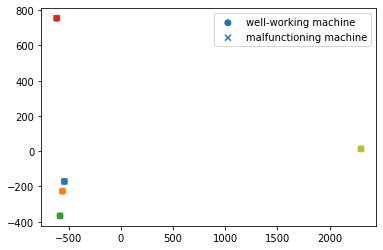

In [50]:
pca = PCA(n_components=2)
emb = pca.fit_transform(np.array(good_time_series+bad_time_series))

f,ax = plt.subplots()
colors = ["tab:blue","tab:orange", "tab:green", "tab:red","tab:olive"]
ax.scatter(emb[:5,0],emb[:5,1], marker = "o", c= colors, label="well-working machine")
ax.scatter(emb[5:,0],emb[5:,1], marker = "x", c=colors, label="malfunctioning machine")
ax.legend()
plt.show()